### Preprocess 10X v2 data from Litvinukova et al. 2020

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [4]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

In [6]:
%%time
# read in the entire dataset
adata = sc.read_h5ad("Teichman_LV_nuclei.h5ad")
Counter(adata.obs.technology)

CPU times: user 384 ms, sys: 1 s, total: 1.39 s
Wall time: 1.38 s


Counter({'3prime-v3': 52058, '3prime-v2': 36763, 'Multiome-v1': 33805})

In [7]:
# add study 
adata.obs['study'] = "Litvinukova 2020"

In [8]:
# filter to 3prime-v2'
adata = adata[adata.obs.technology == '3prime-v2', :].copy()

# store the raw counts
adata.layers["counts"] = adata.X.copy()

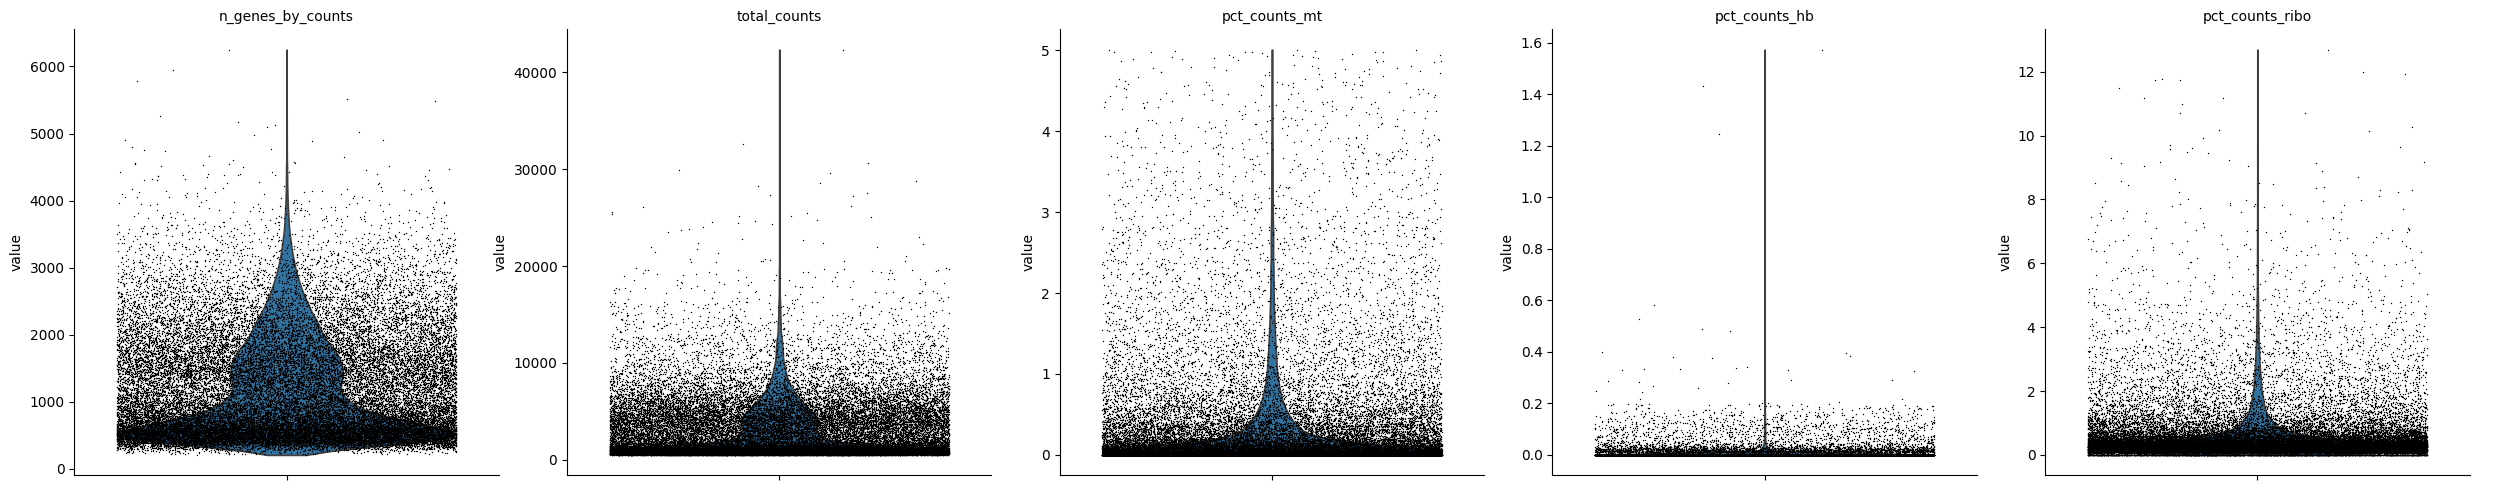

Filtered out 268 cells
CPU times: user 19.5 s, sys: 39.1 s, total: 58.6 s
Wall time: 4.25 s


In [9]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [10]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 37 likely doublets
CPU times: user 9min 9s, sys: 11min 40s, total: 20min 50s
Wall time: 3min 19s


2024-11-23 13:35:02,343 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 13:35:05,476 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 13:35:05,686 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 13:35:15,801 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 13:35:26,470 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 13:35:37,099 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 13:35:47,840 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 13:35:52,831 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 13:35:56,360 - harmonypy - INFO - Iteration 7 of 10
2024-11-23 13:35:59,941 - harmonypy - INFO - Iteration 8 of 10
2024-11-23 13:36:03,637 - harmonypy - INFO - Iteration 9 of 10
2024-11-23 13:36:07,302 - harmonypy - INFO - Converged after 9 iterations


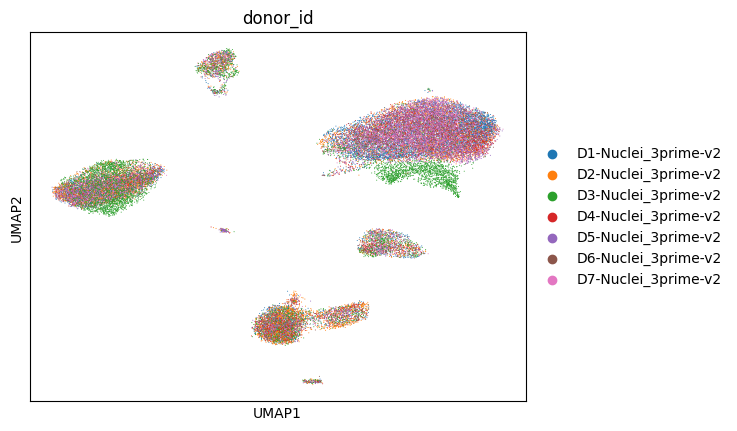

In [11]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

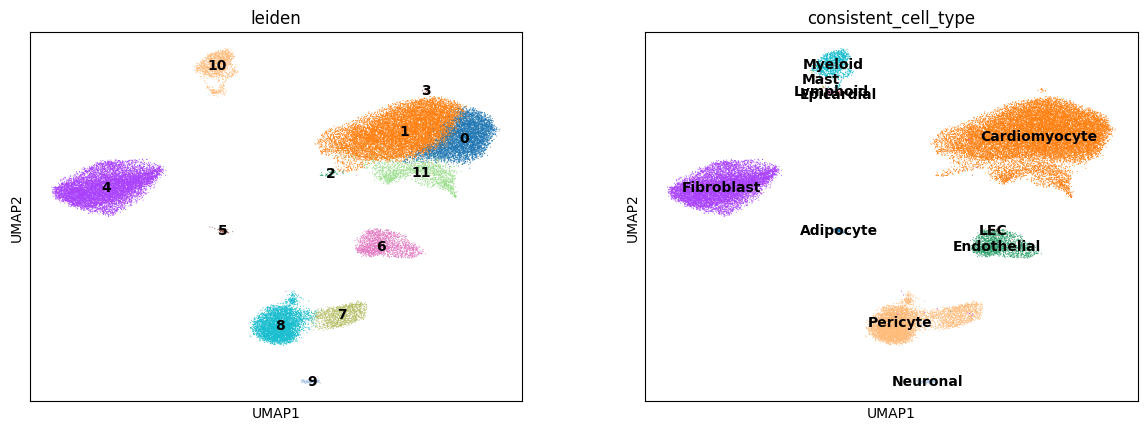

In [12]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [13]:
adata.write("processed_10x_GEX_v2_adata.h5ad")